## Content-Based Boardgame Recommendation Systems

In this notebook, we'll be exploring Board Game data pulled from [boardgamegeek.com](https://www.boardgamegeek.com+) and using it to build content-based recommendation systems.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from wordcloud import WordCloud

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")

In [3]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
filepath = Path('/content/gdrive/MyDrive/DataWorks MD Talk/games_full.csv')
df = pd.read_csv(filepath)
df.head()

,Game_Name,Game_ID,Rank,Geek_Rating,Average_Rating,Number_of_Voters,Description,Year Published,Thumbnail,Image,Categories,Mechanics,Families,Designers,Long_Description,Minplayers,Maxplayers,Playingtime,Minplaytime,Maxplaytime
0,Brass: Birmingham,224517,1,8.426,8.62,37388,"Build networks, grow industries, and navigate ...",2018,https://cf.geekdo-images.com/x3zxjr-Vw5iU4yDPg...,https://cf.geekdo-images.com/x3zxjr-Vw5iU4yDPg...,"['Economic', 'Industry / Manufacturing', 'Post...","['Hand Management', 'Income', 'Loans', 'Market...","['Cities: Birmingham (England)', 'Components: ...","['Gavan Brown', 'Matt Tolman', 'Martin Wallace']",Brass: Birmingham is an economic strategy game...,2,4,120,60,120
1,Pandemic Legacy: Season 1,161936,2,8.395,8.54,50114,Mutating diseases are spreading around the wor...,2015,https://cf.geekdo-images.com/-Qer2BBPG7qGGDu6K...,https://cf.geekdo-images.com/-Qer2BBPG7qGGDu6K...,"['Environmental', 'Medical']","['Action Points', 'Cooperative Game', 'Hand Ma...","['Components: Map (Global Scale)', 'Components...","['Rob Daviau', 'Matt Leacock']",Pandemic Legacy is a co-operative campaign gam...,2,4,60,60,60
2,Gloomhaven,174430,3,8.394,8.63,57589,Vanquish monsters with strategic cardplay. Ful...,2017,https://cf.geekdo-images.com/sZYp_3BTDGjh2unaZ...,https://cf.geekdo-images.com/sZYp_3BTDGjh2unaZ...,"['Adventure', 'Exploration', 'Fantasy', 'Fight...","['Action Queue', 'Action Retrieval', 'Campaign...","['Category: Dungeon Crawler', 'Components: Min...",['Isaac Childres'],Gloomhaven is a game of Euro-inspired tactica...,1,4,120,60,120
3,Ark Nova,342942,4,8.295,8.54,28630,"Plan and build a modern, scientifically manage...",2021,https://cf.geekdo-images.com/SoU8p28Sk1s8MSvoM...,https://cf.geekdo-images.com/SoU8p28Sk1s8MSvoM...,"['Animals', 'Economic', 'Environmental']","['End Game Bonuses', 'Hand Management', 'Hexag...","['Components: Hexagonal Tiles', 'Digital Imple...",['Mathias Wigge'],"In Ark Nova, you will plan and design a modern...",1,4,150,90,150
4,Twilight Imperium: Fourth Edition,233078,5,8.241,8.62,20463,"Build an intergalactic empire through trade, r...",2017,https://cf.geekdo-images.com/_Ppn5lssO5OaildSE...,https://cf.geekdo-images.com/_Ppn5lssO5OaildSE...,"['Civilization', 'Economic', 'Exploration', 'N...","['Action Drafting', 'Area Majority / Influence...","['Components: Hexagonal Tiles', 'Components: M...","['Dane Beltrami', 'Corey Konieczka', 'Christia...",Twilight Imperium (Fourth Edition) is a game o...,3,6,480,240,480


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Game_Name         10000 non-null  object 
 1   Game_ID           10000 non-null  int64  
 2   Rank              10000 non-null  int64  
 3   Geek_Rating       10000 non-null  float64
 4   Average_Rating    10000 non-null  float64
 5   Number_of_Voters  10000 non-null  int64  
 6   Description       6954 non-null   object 
 7   Year Published    10000 non-null  int64  
 8   Thumbnail         9999 non-null   object 
 9   Image             9999 non-null   object 
 10  Categories        10000 non-null  object 
 11  Mechanics         10000 non-null  object 
 12  Families          10000 non-null  object 
 13  Designers         10000 non-null  object 
 14  Long_Description  10000 non-null  object 
 15  Minplayers        10000 non-null  int64  
 16  Maxplayers        10000 non-null  int64  

In [6]:
# Fill Missing Discriptions, Thumbnail and
# Image w/ Empty Strings
df['Description'].fillna('', inplace=True)
df['Thumbnail'].fillna('', inplace=True)
df['Image'].fillna('', inplace=True)
df.isnull().sum().sum()

0

# Data Analysis

In this section we will inspect the distributions of the numerical variables.

For the categorical variables, categories, mechanics and families, we look to identify the most common values for each of them and discare the least common.

## Numerical Columns

In [7]:
numerical_columns = ['Year Published', 'Geek_Rating', 'Average_Rating', 'Number_of_Voters', 
                     'Minplayers', 'Maxplayers','Playingtime']

df[numerical_columns].describe()

,Year Published,Geek_Rating,Average_Rating,Number_of_Voters,Minplayers,Maxplayers,Playingtime
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2003.67690,5.917220,6.998844,2025.569100,1.904200,5.328400,118.336600
std,130.02455,0.453063,0.610102,5939.851328,0.706734,13.029533,472.954189
min,-3500.00000,5.563000,5.630000,43.000000,0.000000,0.000000,0.000000
25%,2008.00000,5.609000,6.540000,218.750000,1.000000,4.000000,30.000000
50%,2015.00000,5.725000,6.940000,489.000000,2.000000,4.000000,60.000000
75%,2019.00000,6.048000,7.400000,1405.750000,2.000000,6.000000,91.250000
max,2024.00000,8.426000,9.340000,118786.000000,9.000000,999.000000,22500.000000


In [8]:
plt.style.use('dark_background')

DescribeResult(nobs=10000, minmax=(5.63, 9.34), mean=6.998844, variance=0.3722242060846085, skewness=0.4747155425396764, kurtosis=-0.10924780987888116)

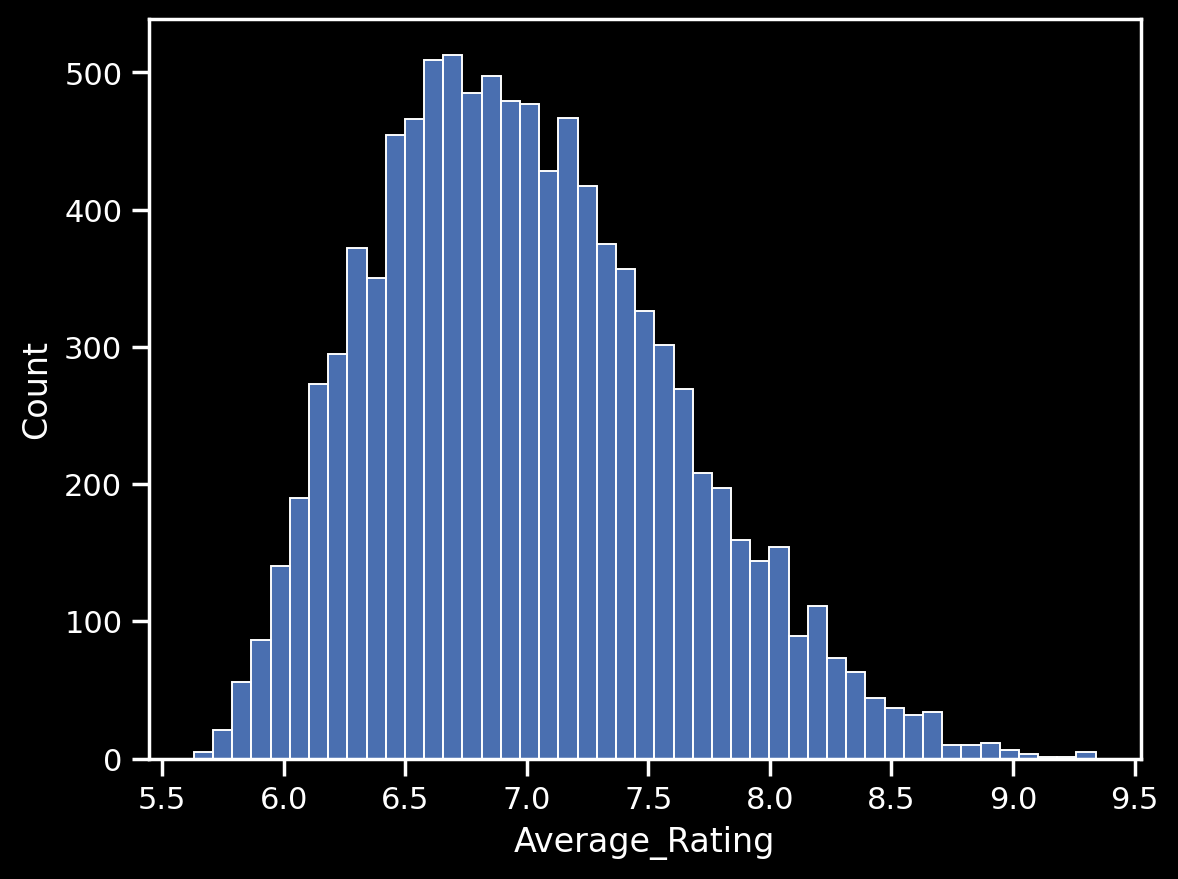

In [9]:
ax = sns.histplot(df['Average_Rating'], color='cornflowerblue')
stats.describe(df['Average_Rating'])

Average Ratings are pleasantly normally distributed.

DescribeResult(nobs=10000, minmax=(5.563, 8.426), mean=5.9172201, variance=0.2052660466606561, skewness=1.9239966258914045, kurtosis=3.704258297979158)

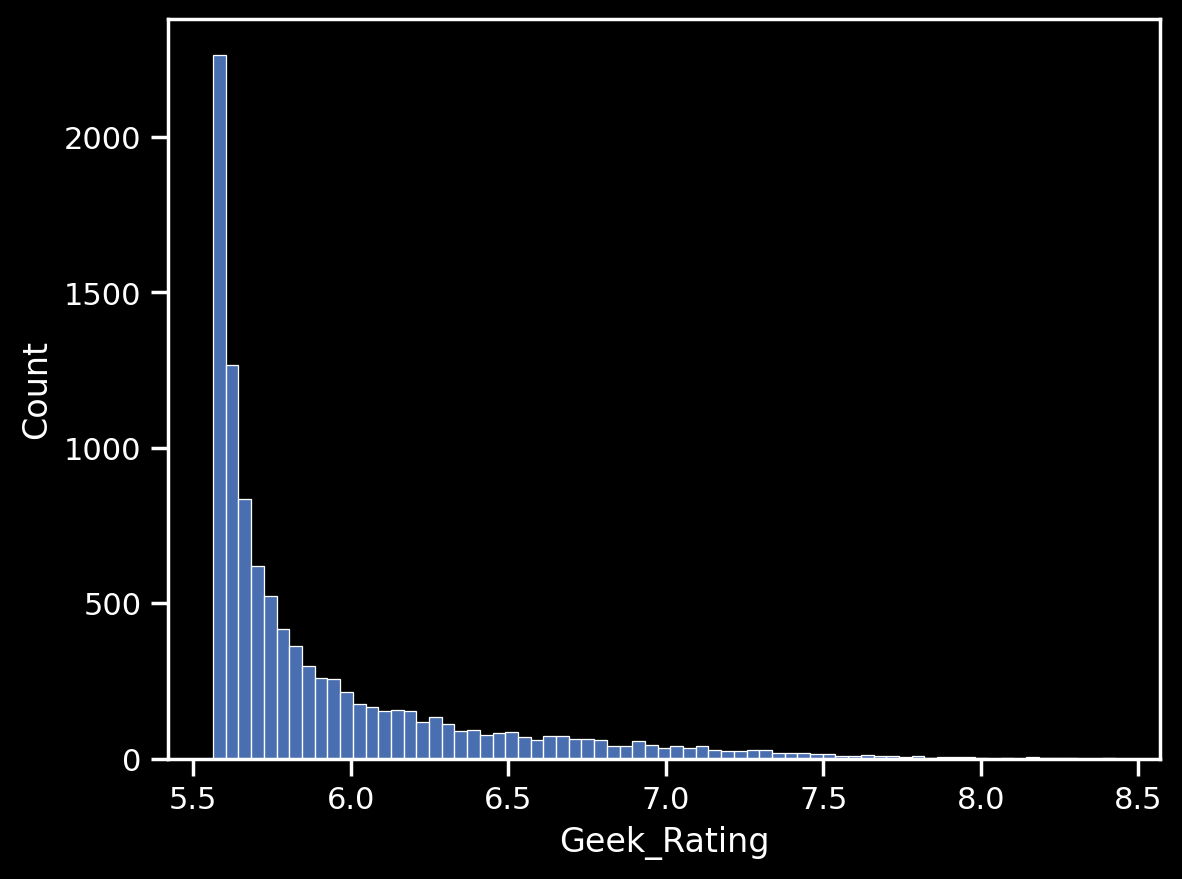

In [10]:
ax = sns.histplot(df['Geek_Rating'], color='cornflowerblue')
stats.describe(df['Geek_Rating'])

The Geek Rating of a game is a baysean average. The specifics aren't entirely know, but we do know that lots of dummy 5.5 votes are included. This prevents new games with low number of votes from rocketing up the ratings charts.  [Source](https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ#toc4)

We see the effect here. Geek Averages are pulled dramatically back and it seems very difficult for the geek rating of any game to get past 6.

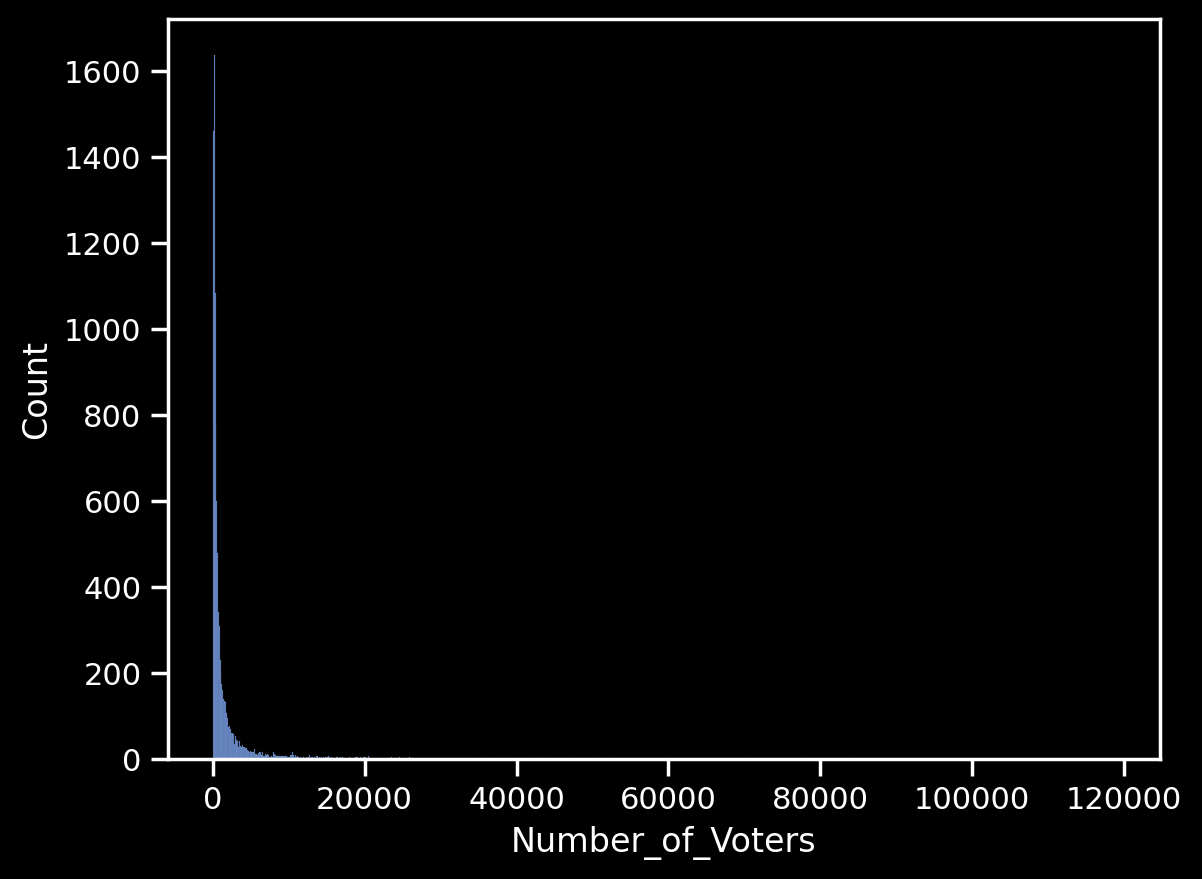

In [11]:
ax = sns.histplot(df['Number_of_Voters'], color='cornflowerblue')

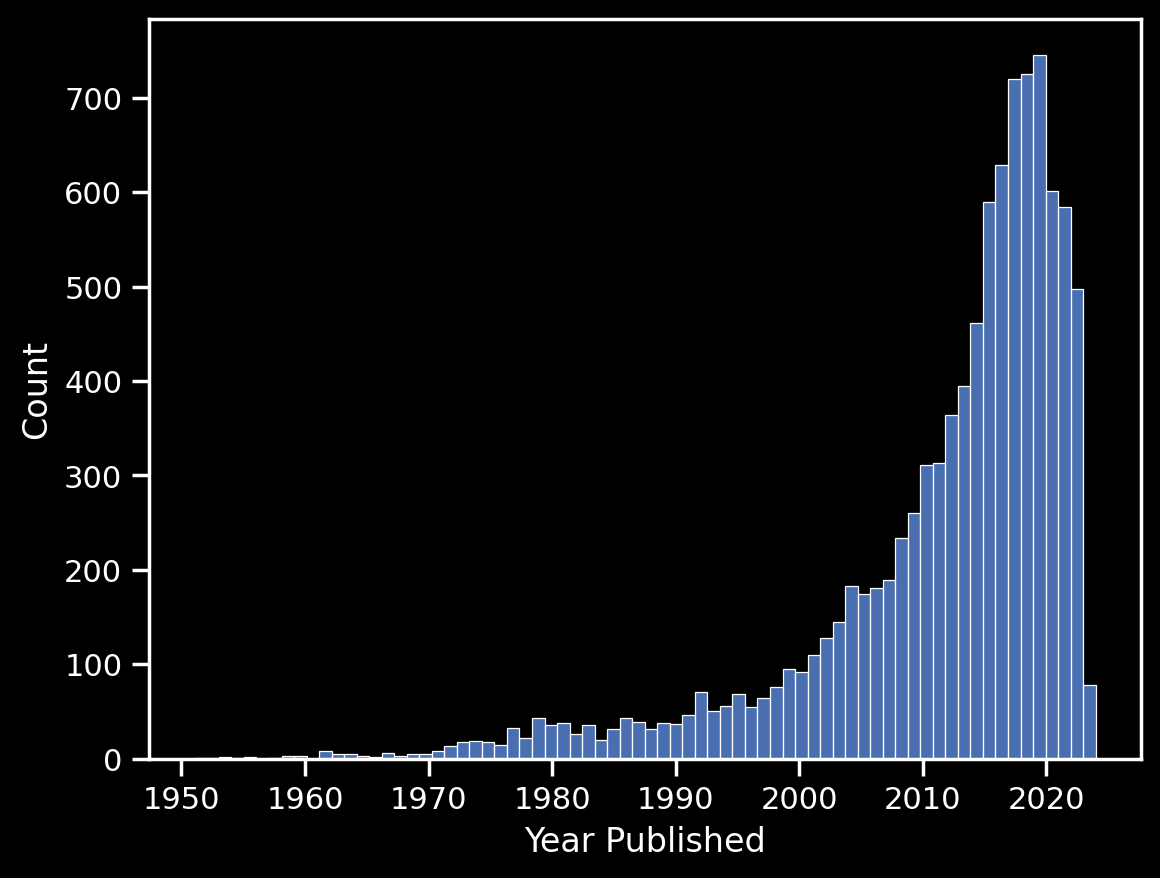

In [12]:
# There are a few outlier year releases. We will exclude them from our histogram.
Year_Published = df[df['Year Published'] > 1950]['Year Published']

ax = sns.histplot(Year_Published, color='cornflowerblue')

If there's a graph to illustrate the explosion in modern boardgaming, it's this one. The overwhelming majority of games in our dataset were released after the year 2000.

## Categorical Variables

Let's break down the three categorical variables and inspect which values are most common.

In [13]:
cat_cols = ['Categories', 'Mechanics', 'Families', 'Designers']

# go through each value in the column, split on the columns and keep track of frequencies
def get_frequencies(column):
  values = {}

  for value in column:
      for word in value[1:-1].split(','):
          g = word.strip()[1:-1]

          if g == '':
            continue

          if g not in values.keys():
              values[g] = 0

          values[g] = values[g] + 1

  #sort dictionary by frequencies
  #values = dict(sorted(values.items(), key=lambda item: item[1], reverse=True))
  freq_df = pd.DataFrame.from_dict(values, orient='index')
  freq_df.rename(columns={0: 'Frequency'}, inplace=True)
  freq_df['Relative_Freq'] = freq_df['Frequency'] / 10000
  freq_df.sort_values('Frequency', ascending=True, inplace=True)
  return freq_df

# find and record the frequencies of each value for the three cagegorical columns
cat_freq = {}

for column in cat_cols:

  cat_freq[column] = get_frequencies(df[column])
  print('Unique {} found: {}'.format(column, len(cat_freq[column])))


Unique Categories found: 84
Unique Mechanics found: 195
Unique Families found: 2992
Unique Designers found: 5129


In [17]:
cat_freq['Categories']['Frequency']

Fan Expansion                 1
Korean War                    7
Expansion for Base-game      12
Game System                  13
American Indian Wars         24
                           ... 
Science Fiction             936
Fighting                    970
Fantasy                    1597
Wargame                    1822
Card Game                  2876
Name: Frequency, Length: 84, dtype: int64

There are a whole lot of possible values for each of our categorical varibales. It will help our train tim to cut out the rarest values.

In [19]:
def cat_info(freq_dict, title):

  plt.barh(freq_dict.index.tolist(), freq_dict['Frequency'], color='cornflowerblue')
  plt.title('{} Frequencies'.format(title))
  plt.show()

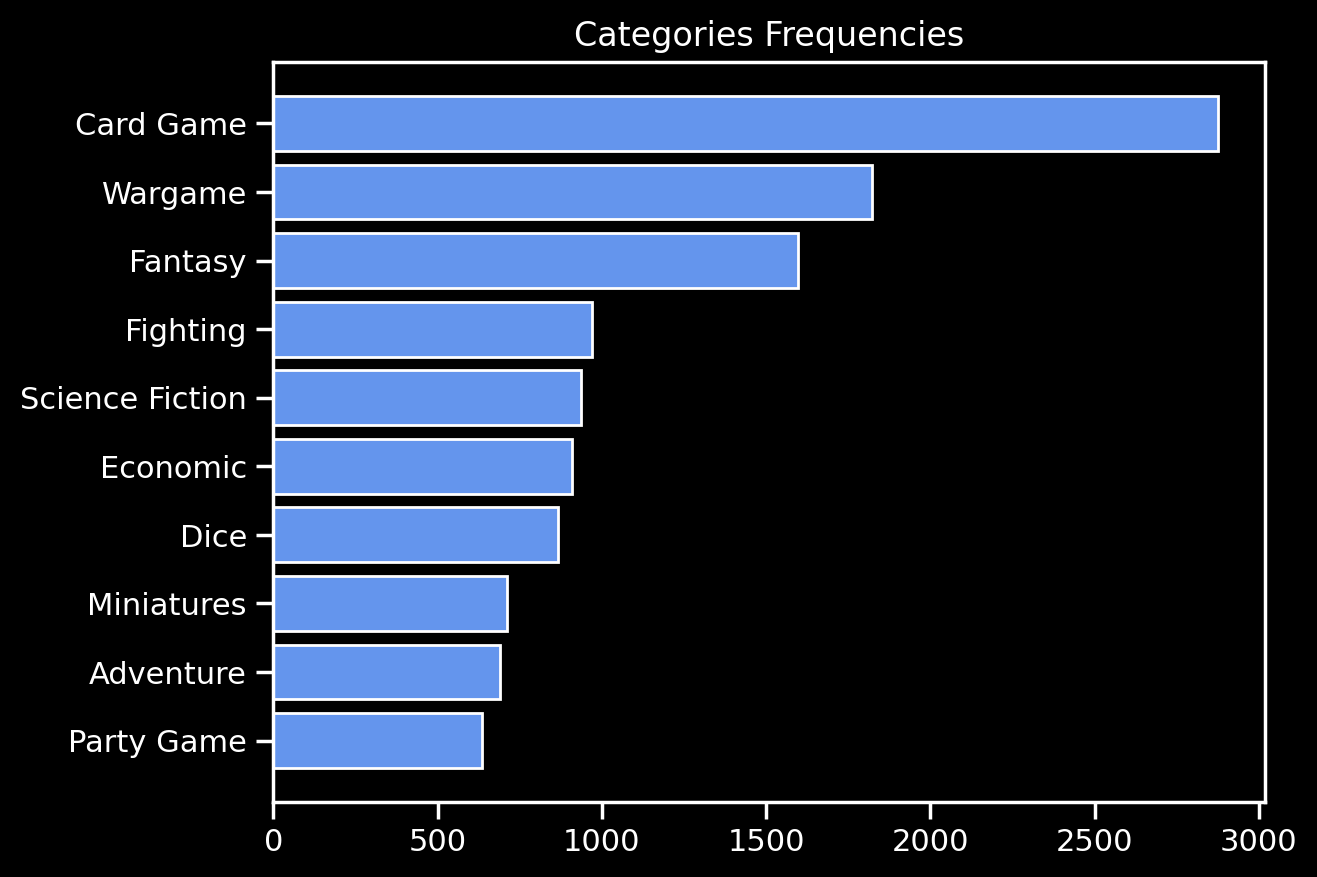

,Frequency,Relative_Freq
Puzzle,419,0.0419
City Building,423,0.0423
Ancient,438,0.0438
Bluffing,541,0.0541
Exploration,579,0.0579
Deduction,586,0.0586
Medieval,592,0.0592
Abstract Strategy,593,0.0593
World War II,609,0.0609
Animals,629,0.0629


In [20]:
cat_info(cat_freq['Categories'][-10:], 'Categories')
cat_freq['Categories'].tail(20)

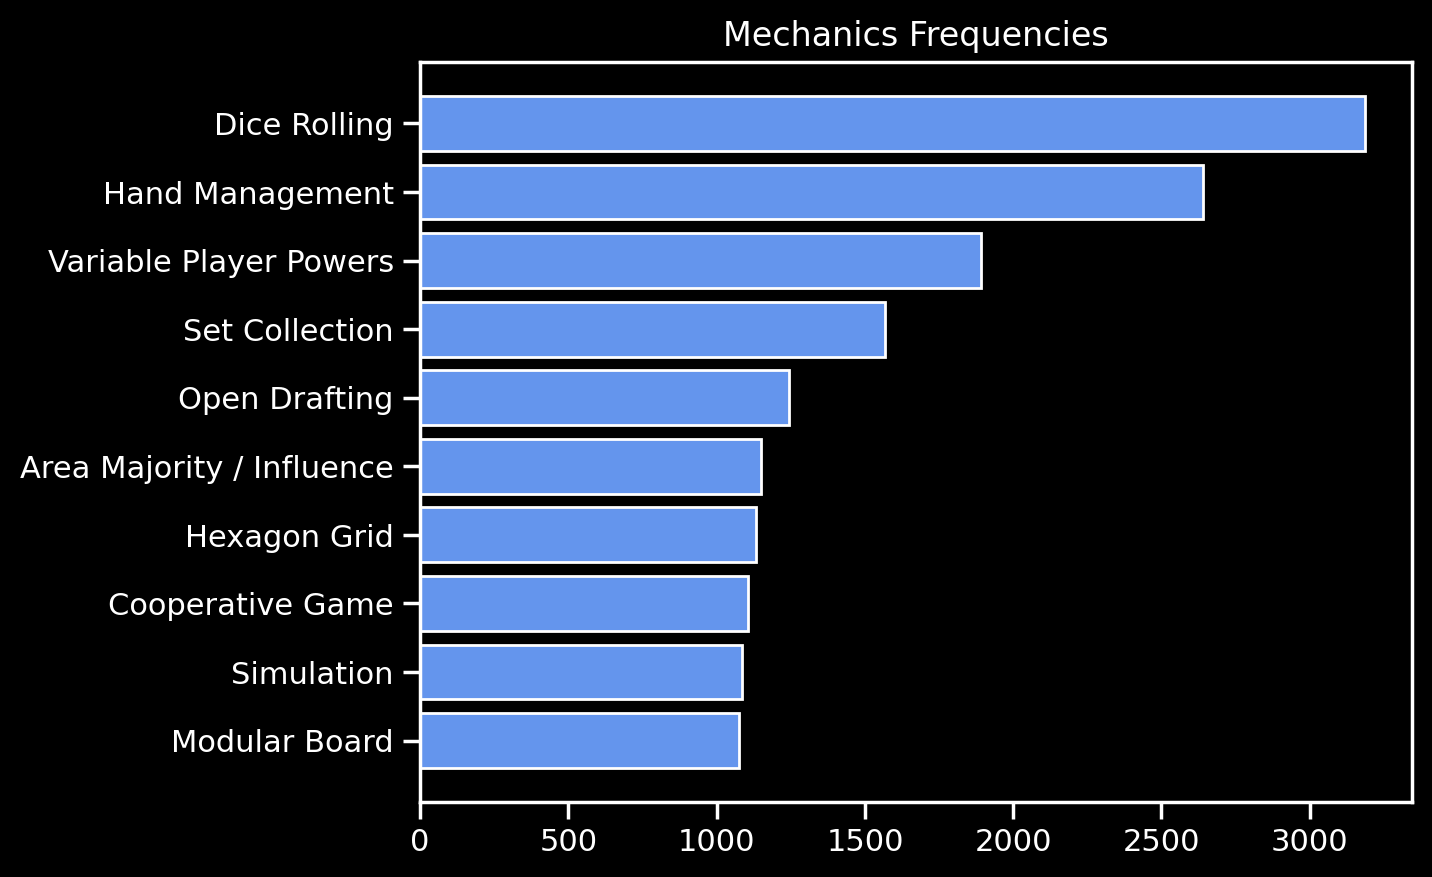

,Frequency,Relative_Freq
Modular Board,1076,0.1076
Simulation,1084,0.1084
Cooperative Game,1107,0.1107
Hexagon Grid,1132,0.1132
Area Majority / Influence,1150,0.1150
Open Drafting,1243,0.1243
Set Collection,1567,0.1567
Variable Player Powers,1892,0.1892
Hand Management,2640,0.2640
Dice Rolling,3186,0.3186


In [21]:
cat_info(cat_freq['Mechanics'][-10:], 'Mechanics')
cat_freq['Mechanics'].tail(10)

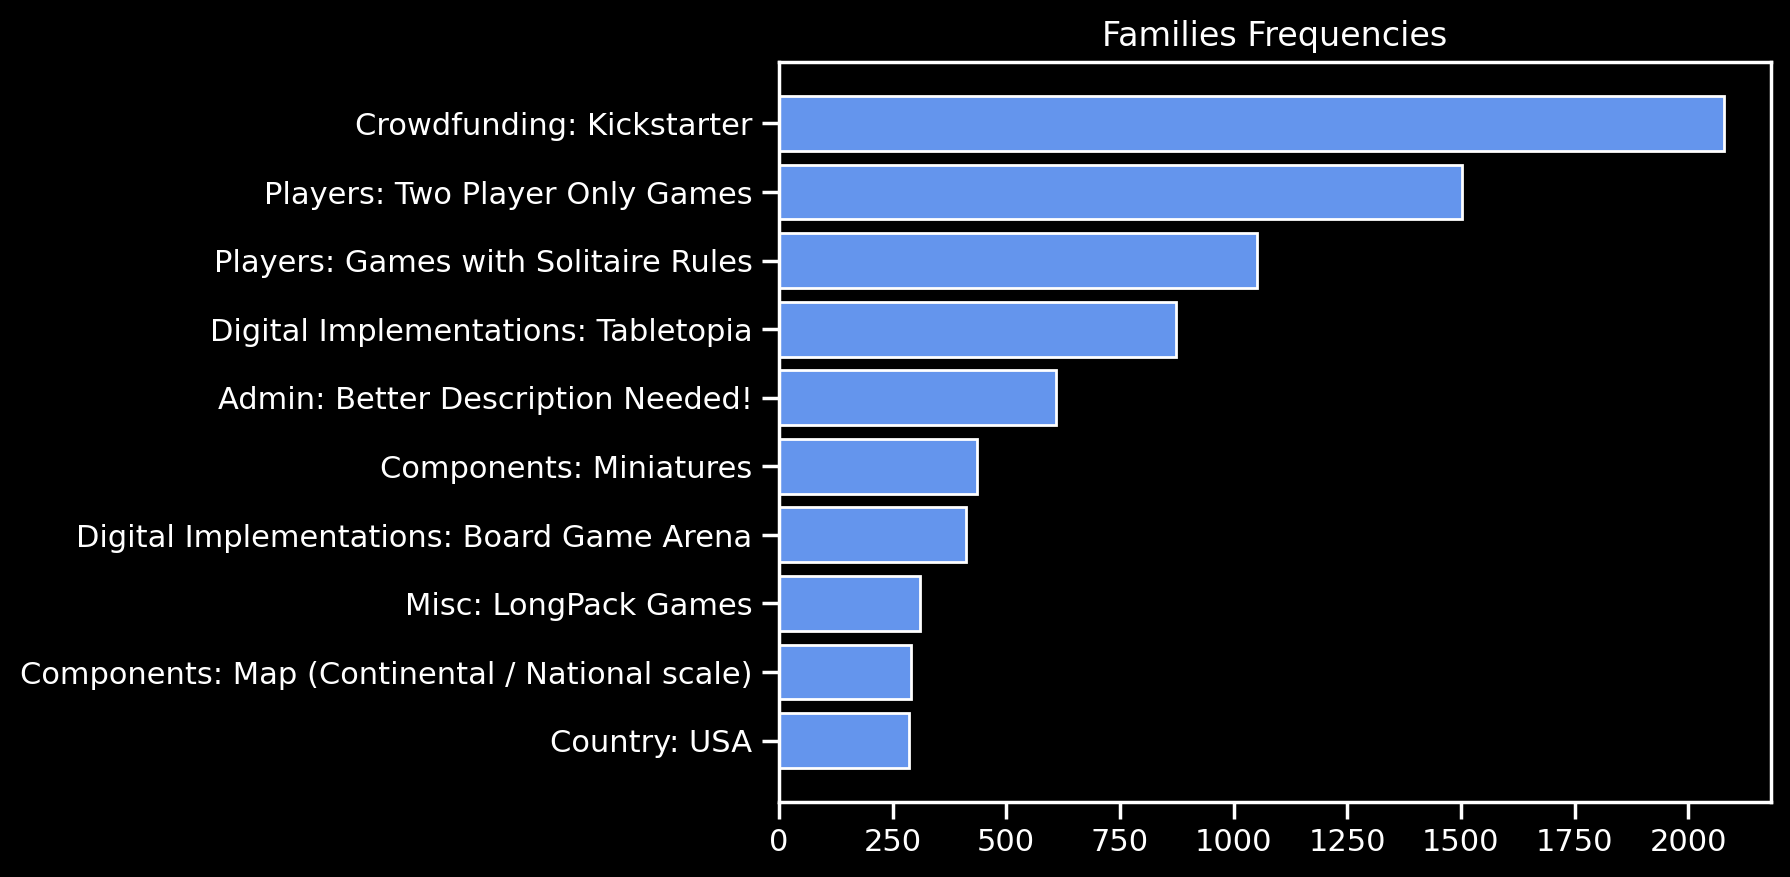

,Frequency,Relative_Freq
Country: USA,287,0.0287
Components: Map (Continental / National scale),291,0.0291
Misc: LongPack Games,311,0.0311
Digital Implementations: Board Game Arena,411,0.0411
Components: Miniatures,436,0.0436
Admin: Better Description Needed!,609,0.0609
Digital Implementations: Tabletopia,874,0.0874
Players: Games with Solitaire Rules,1052,0.1052
Players: Two Player Only Games,1502,0.1502
Crowdfunding: Kickstarter,2078,0.2078


In [22]:
#there are a ton of families
fam_list = cat_freq['Families'][cat_freq['Families'] > 100]

cat_info(fam_list[-10:], 'Families')
cat_freq['Families'].tail(10)

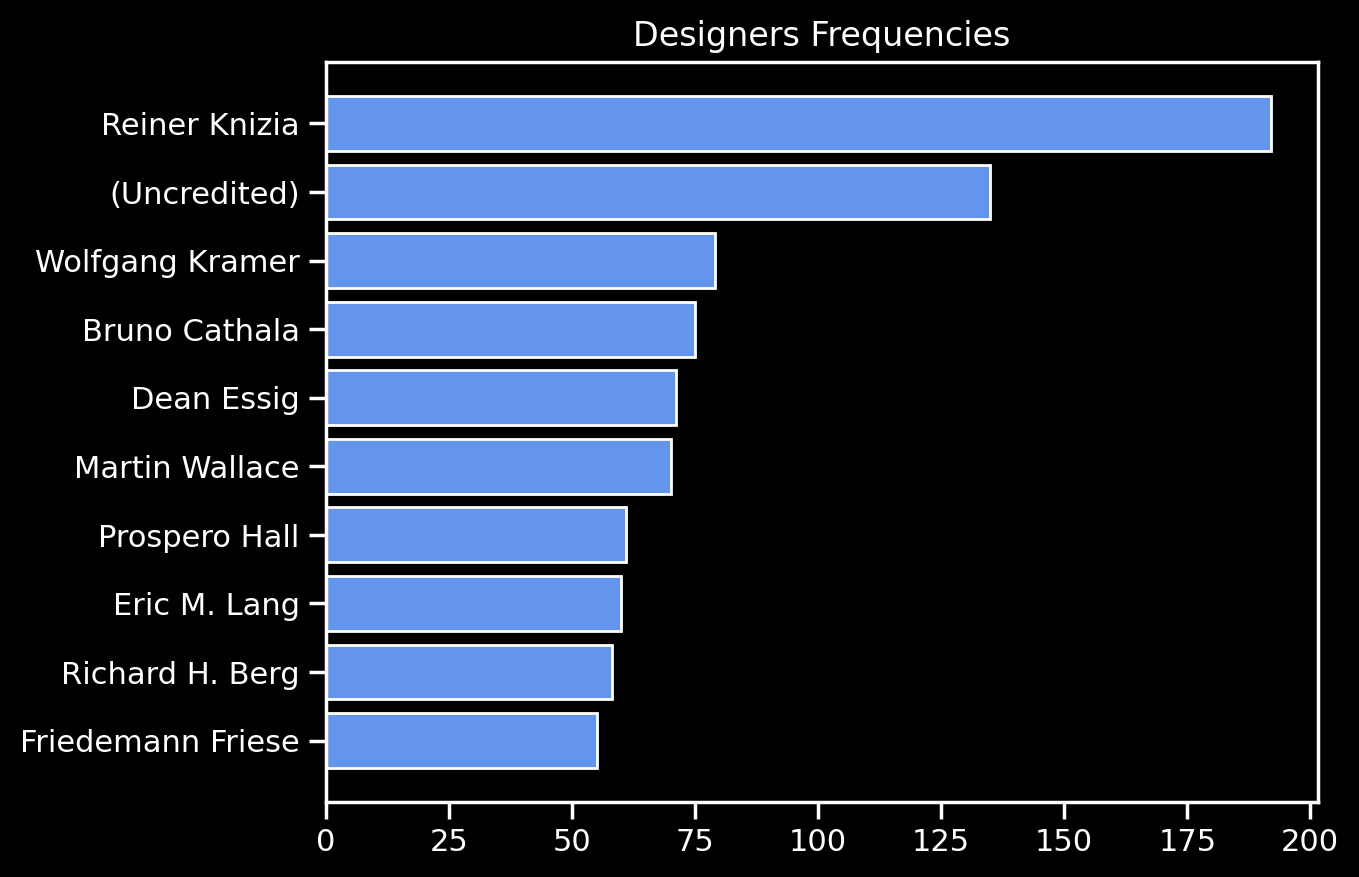

,Frequency,Relative_Freq
Friedemann Friese,55,0.0055
Richard H. Berg,58,0.0058
Eric M. Lang,60,0.0060
Prospero Hall,61,0.0061
Martin Wallace,70,0.0070
Dean Essig,71,0.0071
Bruno Cathala,75,0.0075
Wolfgang Kramer,79,0.0079
(Uncredited),135,0.0135
Reiner Knizia,192,0.0192


In [ ]:
cat_info(cat_freq['Designers'][-10:], 'Designers')
cat_freq['Designers'].tail(10)

# Create Categorical Columns

For Our recommendation system will find the distance between games, we need to transform our categorical variables to numerical. First, well throw out any family, mechanic or category that appears in less than 1% of our games.

Then a column will be added for each value left. 1 will represent its presence and 0 its absense for the game.

In [23]:
# number to cutoff at
cutoff = 0.001 * 100000

# weights for categories, mechanics and families
cat_weights = {'Categories': 3, 'Mechanics': 2, 'Families': 1}

# Record all the columns we add to the dataframe
columns_added = []

for category in cat_weights.keys():
  cat_df = cat_freq[category]

  # cut off the rarest values
  cat_df = cat_df[cat_df['Frequency'] >= cutoff]

  print('{} values left for {}.'.format(len(cat_df.index), category))

  # create a new column for values left and make it equal to the weight of the category if
  # present for the current game
  for value in cat_df.index:
    df[value] = 0
    df[value] = [cat_weights[category] if value in x else 0 for x in df[category]]
    columns_added.append(value)


62 values left for Categories.
66 values left for Mechanics.
42 values left for Families.


In [25]:
columns_added[:20]

['Zombies',
 'World War I',
 'Age of Reason',
 'Memory',
 'American Civil War',
 'Travel',
 'Post-Napoleonic',
 'Spies/Secret Agents',
 'American West',
 'Environmental',
 'Pirates',
 'Word Game',
 'Farming',
 'Modern Warfare',
 'Educational',
 'Napoleonic',
 'Aviation / Flight',
 'Comic Book / Strip',
 'Collectible Components',
 'Murder/Mystery']

In [27]:
df.iloc[0][columns_added]

Zombies                                0
World War I                            0
Age of Reason                          0
Memory                                 0
American Civil War                     0
                                      ..
Admin: Better Description Needed!      0
Digital Implementations: Tabletopia    1
Players: Games with Solitaire Rules    0
Players: Two Player Only Games         0
Crowdfunding: Kickstarter              1
Name: 0, Length: 170, dtype: object

# Nearest Neighbors Recommendation System

For our model, we will use our data to find the euclidean distances between games.

In [28]:
#make a category dataframe with bgg_id as the index for knn calculations
categories = df[columns_added + ['Game_ID']].copy()

# make sure the game id is indexed so it's not used for calculating distances
categories.set_index('Game_ID', inplace=True)

In [29]:
categories

,Zombies,World War I,Age of Reason,Memory,American Civil War,Travel,Post-Napoleonic,Spies/Secret Agents,American West,Environmental,...,Country: USA,Components: Map (Continental / National scale),Misc: LongPack Games,Digital Implementations: Board Game Arena,Components: Miniatures,Admin: Better Description Needed!,Digital Implementations: Tabletopia,Players: Games with Solitaire Rules,Players: Two Player Only Games,Crowdfunding: Kickstarter
Game_ID,,,,,,,,,,,,,,,,,,,,,
224517,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,1,0,0,1
161936,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
174430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
342942,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,1,0,0
233078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
356224,0,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [30]:
# CATAN vector
categories.loc[13][categories.loc[13] > 0]

Negotiation                                  3
Economic                                     3
Income                                       2
Race                                         2
Trading                                      2
Variable Set-up                              2
Network and Route Building                   2
a                                            2
Modular Board                                2
Hexagon Grid                                 2
Dice Rolling                                 2
Digital Implementations: Steam               1
Components: Wooden pieces & boards           1
Digital Implementations: Board Game Arena    1
Name: 13, dtype: int64

In [36]:
# Instantiate our model with the categorical data and set it to find the nearest 10 neighbors
knn = NearestNeighbors(metric='minkowski', algorithm='brute', n_neighbors=11, n_jobs=-1)
knn.fit(categories)

NearestNeighbors(algorithm='brute', n_jobs=-1, n_neighbors=11)

In [66]:
distances, ids = knn.kneighbors([categories.loc[13]])
print(df[df['Game_ID'] == 13][['Game_Name', 'Rank']])
pd.DataFrame(zip(distances[0], ids[0]), columns=['distances', 'integer index'])

    Game_Name  Rank
491     CATAN   492


,distances,ranks/integer index
0,0.000000,491
1,5.656854,6812
2,6.000000,4255
3,6.244998,6870
4,6.244998,9090
5,6.403124,4253
6,6.403124,150
7,6.480741,3793
8,6.633250,7845
9,6.633250,1194


In [34]:
# function that takes a game, finds a list of its nearest neighbors and gets those games' information from the main df

def get_neighborhood(knn, game, features):
    distances, near_games = knn.kneighbors([features.loc[game]])

    neighbor_games = pd.DataFrame()
    neighbor_games['Game_ID'] = categories.index[near_games[0]]
    neighbor_games['distance'] = distances[0]
    
    return neighbor_games.merge(df, on='Game_ID').copy()

In [54]:
# helper function to display the game and a link to its BGG page
def display_recommendations(df_recs):
  for index, game in df_recs.iterrows():
    if index == 0:
      print('Recomendations for {}({}) - {}'.format(game['Game_Name'], int(game['Year Published']), game['Geek_Rating']))
      print('https://boardgamegeek.com/boardgame/{}'.format(game['Game_ID']))
      print('')
    else:
      print('{}. {}({}) - {}: https://boardgamegeek.com/boardgame/{}'.format(index, game['Game_Name'], int(game['Year Published']),game['Geek_Rating'], game['Game_ID']))
      print('\t{}\n'.format(game['Description'])) 


We'll start testing our implementation by looking at the, currently, number one ranked game, Gloomhaven.

In [68]:
df_recs = get_neighborhood(knn, 224517, categories)
display_recommendations(df_recs)

Recomendations for Brass: Birmingham(2018) - 8.426
https://boardgamegeek.com/boardgame/224517

1. Brass: Lancashire(2007) - 7.967: https://boardgamegeek.com/boardgame/28720
	Test your economic mettle as you build and network in the Industrial Revolution.

2. Findorff(2022) - 5.781: https://boardgamegeek.com/boardgame/360617
	Build up Findorff by raising the main structures and rail tracks.

3. 1841: Railways in Northern Italy(1994) - 5.854: https://boardgamegeek.com/boardgame/1447
	A complex 18xx in which companies can invest in, and even start, other companies.

4. Wabash Cannonball(2007) - 6.906: https://boardgamegeek.com/boardgame/31730
	Build track and buy stock to get the most money in this railroad race to Chicago.

5. 1849: The Game of Sicilian Railways(1998) - 6.297: https://boardgamegeek.com/boardgame/3097
	The poor get poorer in this economic beatdown set on the island of Sicily.

6. Age of Industry(2010) - 6.622: https://boardgamegeek.com/boardgame/65901
	

7. The Grand Trun

In [67]:
df_recs = get_neighborhood(knn, 335869, categories)
display_recommendations(df_recs)

Recomendations for A Little Wordy(2021) - 5.857
https://boardgamegeek.com/boardgame/335869

1. Scarabeo(1963) - 5.635: https://boardgamegeek.com/boardgame/12747
	

2. Super Scrabble(2004) - 5.667: https://boardgamegeek.com/boardgame/11182
	

3. Jarnac(1977) - 5.607: https://boardgamegeek.com/boardgame/7451
	Make the longest words possible or extend existing ones until 8 lines are completed.

4. Upwords(1982) - 5.617: https://boardgamegeek.com/boardgame/1515
	A 3-dimensional word game. Spell out, stack up and score high!

5. What's My Word?(1972) - 5.764: https://boardgamegeek.com/boardgame/4079
	Deduce your opponent's secret word by guessing shorter words that partially match.

6. P for Pizza(2020) - 5.58: https://boardgamegeek.com/boardgame/311330
	Now's your chance to build your own giant slice of pizza!

7. Bananagrams WildTiles(2014) - 5.573: https://boardgamegeek.com/boardgame/164917
	

8. Prolix(2010) - 5.616: https://boardgamegeek.com/boardgame/39635
	

9. Spukstaben(2020) - 5.6

In [74]:
df_recs = get_neighborhood(knn, 171, categories)
display_recommendations(df_recs)

Recomendations for Chess(1475) - 6.996
https://boardgamegeek.com/boardgame/171

1. International Checkers(1600) - 5.604: https://boardgamegeek.com/boardgame/26952
	

2. Gyges(1985) - 5.683: https://boardgamegeek.com/boardgame/10527
	Bounce your way to the promise land.

3. Mixtour(2011) - 5.632: https://boardgamegeek.com/boardgame/90942
	Build a 5-stack by moving kind of backwards.

4. SHŌBU(2019) - 6.405: https://boardgamegeek.com/boardgame/272380
	Use your stones to push all your opponent's stones off any one of four boards to win!

5. Shogi(1587) - 6.325: https://boardgamegeek.com/boardgame/2065
	Deploy captured pieces for rapid checkmates in Japan's traditional "general's game."

6. Ordo(2009) - 5.581: https://boardgamegeek.com/boardgame/41006
	Reach for the other side and maintain the connection at the same time.

7. Six Making(2013) - 5.7: https://boardgamegeek.com/boardgame/149910
	

8. Kamisado Max(2014) - 5.63: https://boardgamegeek.com/boardgame/153498
	

9. Barragoon(2014) -

Here we get a nice list of abstract game.

In [70]:
df_recs = get_neighborhood(knn, 13, categories)
display_recommendations(df_recs)

Recomendations for CATAN(1995) - 6.938
https://boardgamegeek.com/boardgame/13

1. Catan: Family Edition(2012) - 5.631: https://boardgamegeek.com/boardgame/147240
	

2. Catan Histories: Rise of the Inkas(2018) - 5.787: https://boardgamegeek.com/boardgame/244144
	Relive the rise and fall of Inkas, Catan style!

3. Offshore(2019) - 5.628: https://boardgamegeek.com/boardgame/283867
	Semi-cooperatively build oil reserves off the coast of Norway.

4. Vernissage(1993) - 5.577: https://boardgamegeek.com/boardgame/332
	A game of speculation and dirty tricks in the art world.

5. Catan: Ancient Egypt(2014) - 5.788: https://boardgamegeek.com/boardgame/161527
	Gather your resources and build settlements in the fertile Nile Valley!

6. Istanbul(2014) - 7.401: https://boardgamegeek.com/boardgame/148949
	Send your assistants through the shops of Istanbul as you race to acquire rubies.

7. Franchise(2018) - 5.835: https://boardgamegeek.com/boardgame/245645
	Spread your franchise across USA to control 

In [71]:
df_recs = get_neighborhood(knn, 320, categories)
display_recommendations(df_recs)

Recomendations for Scrabble(1948) - 6.15
https://boardgamegeek.com/boardgame/320

1. Upwords(1982) - 5.617: https://boardgamegeek.com/boardgame/1515
	A 3-dimensional word game. Spell out, stack up and score high!

2. Scarabeo(1963) - 5.635: https://boardgamegeek.com/boardgame/12747
	

3. Super Scrabble(2004) - 5.667: https://boardgamegeek.com/boardgame/11182
	

4. A Little Wordy(2021) - 5.857: https://boardgamegeek.com/boardgame/335869
	A sneaky tile-unscrambling game for aspiring geniuses and would-be word wizards.

5. SHH(2015) - 5.709: https://boardgamegeek.com/boardgame/164158
	Cooperate in silence to spell words and rid your hands of as many letters as possible

6. Jarnac(1977) - 5.607: https://boardgamegeek.com/boardgame/7451
	Make the longest words possible or extend existing ones until 8 lines are completed.

7. P for Pizza(2020) - 5.58: https://boardgamegeek.com/boardgame/311330
	Now's your chance to build your own giant slice of pizza!

8. What's My Word?(1972) - 5.764: https

In [72]:
df_recs = get_neighborhood(knn, 100423, categories)
display_recommendations(df_recs)

Recomendations for Elder Sign(2011) - 6.8
https://boardgamegeek.com/boardgame/100423

1. Set a Watch(2019) - 6.533: https://boardgamegeek.com/boardgame/228855
	Fight to keep your party alive as darkness brings death and destruction.

2. Arkham Horror (Third Edition)(2018) - 7.138: https://boardgamegeek.com/boardgame/257499
	Piece the clues together to stop the horrors before your sanity shatters.

3. The Dresden Files Cooperative Card Game(2017) - 6.196: https://boardgamegeek.com/boardgame/187273
	As a character from the books, solve cases and beat the odds in the final showdown.

4. Set a Watch: Swords of the Coin(2021) - 5.989: https://boardgamegeek.com/boardgame/307386
	

5. The Masters' Trials: Wrath of Magmaroth(2017) - 5.633: https://boardgamegeek.com/boardgame/227171
	

6. One Deck Dungeon: Forest of Shadows(2017) - 6.435: https://boardgamegeek.com/boardgame/224821
	The dice-chucking dungeon delver gets poison.

7. Shadows of Kilforth: A Fantasy Quest Game(2019) - 5.892: https:/

# TF-IDF Description Similarity Recommender

We will make an alternative model looking at the kinds of words used in the longer descriptions of the games. The idea being that similar games will use similar words within their descriptions. Our assumption with this recommender will be that descriptions are written with the most relevant information in mind.

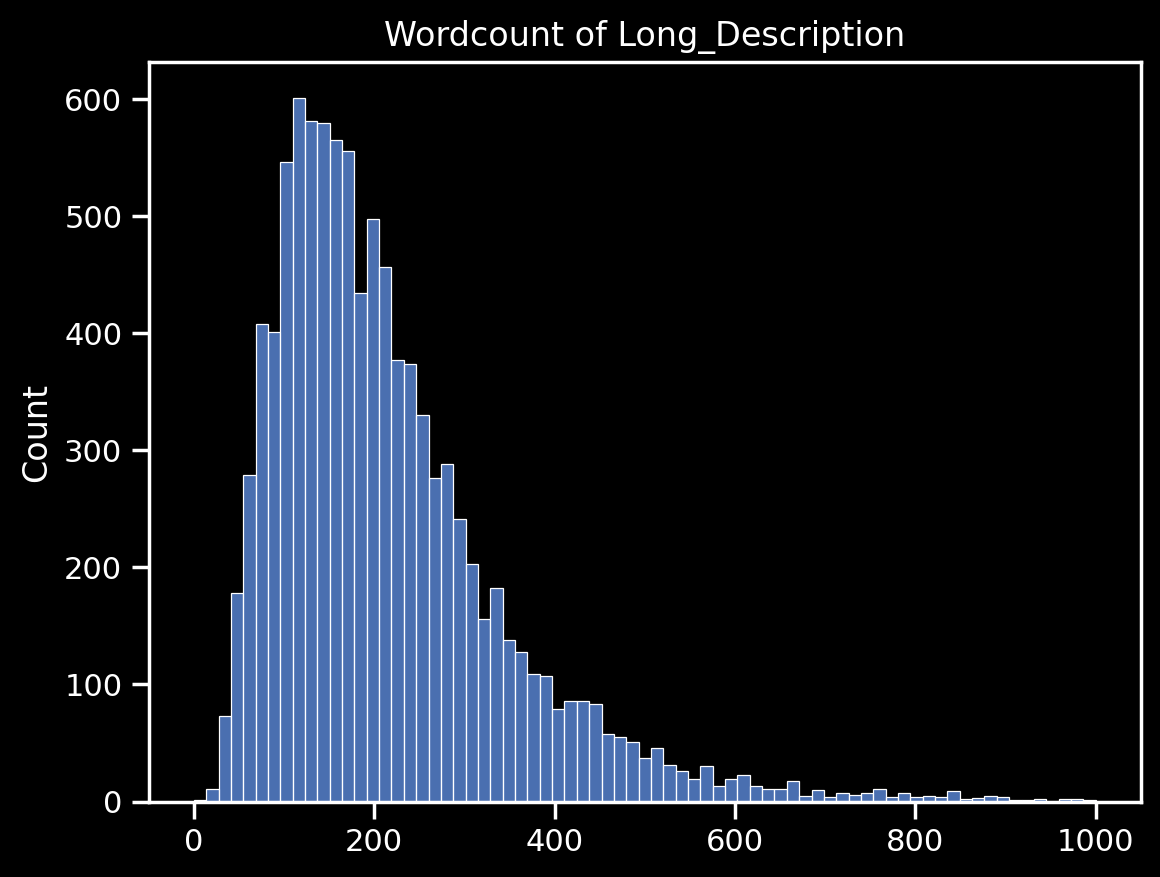

In [75]:
desc_lengths = [len(x.split()) for x in df['Long_Description'].tolist()]
ax = sns.histplot(desc_lengths, binrange=[0,1000], color='cornflowerblue')
plt.title('Wordcount of Long_Description')
plt.show()

The vast majority of detailed descriptions have more than two hundered words. This should be enough for TF-IDF.

$$ w_{i, j} = \text{tf}_{i, j} \cdot \log (\frac{N}{\text{df}_{i}}) $$

$w_{i, j} \rightarrow $ weight of term $i$ in document $j$

$\text{tf}_{i, j} \rightarrow $ term frequency of term $i$ in document $j$

$N \rightarrow$ number of documents in the corpus

$\text{df}_{i} \rightarrow$ number of documents containing term $i$

Taken from goodboychan.github.io

[Graph of IDF Part](https://www.desmos.com/calculator/azxoqasewk)

In [76]:
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(df['Long_Description'])

tfidf_matrix.shape

(10000, 49355)

Our vocabulary has ended up with over forty-nine thousand words. We'll next turn our matrix into a more readable dataframe.

In [77]:
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), 
                        columns=tfidf.get_feature_names_out(),
                        index=df['Game_Name'])

df_tfidf

,00,000,000m,000men,001,002,007,00h,01,011,...,zwischendurch,zwnj,zwo,zwyci,zygmunta,zygons,zyska,zyskiwa,zz,zzzs
Game_Name,,,,,,,,,,,,,,,,,,,,,
Brass: Birmingham,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pandemic Legacy: Season 1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gloomhaven,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ark Nova,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Twilight Imperium: Fourth Edition,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cartoon Network Crossover Crisis: Animation Annihilation Deck-Building Game,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Jours de Gloire Campagne IV: Allemagne 1813, de Lützen à Leipzig",0.0,0.044964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Battles of Normandy: A Solitaire Wargame,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
df_tfidf.loc['CATAN'][df_tfidf.loc['CATAN'] >= 0.1]

10             0.101321
brick          0.110283
cards          0.127058
catan          0.504483
desert         0.128621
development    0.107323
edition        0.186056
editions       0.127998
ore            0.105136
placed         0.108773
produce        0.196405
produces       0.104191
resource       0.329411
robber         0.111701
rolled         0.116804
settlements    0.136573
settlers       0.137478
sheep          0.100897
tile           0.117967
tiles          0.105360
wheat          0.108372
Name: CATAN, dtype: float64

In [79]:
# helper function to make wordclouds of TFIDF data
# filter_zeroes to True if it throws a div by zero error
def make_wordcloud(word_list, filter_zeroes=False):

  if filter_zeroes:
    word_list = word_list[word_list > 0]

  wc = WordCloud(background_color='black',width=5000,height=5000,max_words=100,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(word_list)
  
  plt.xticks([])
  plt.yticks([])
  plt.box(False)
  plt.imshow(wc)
  plt.show()

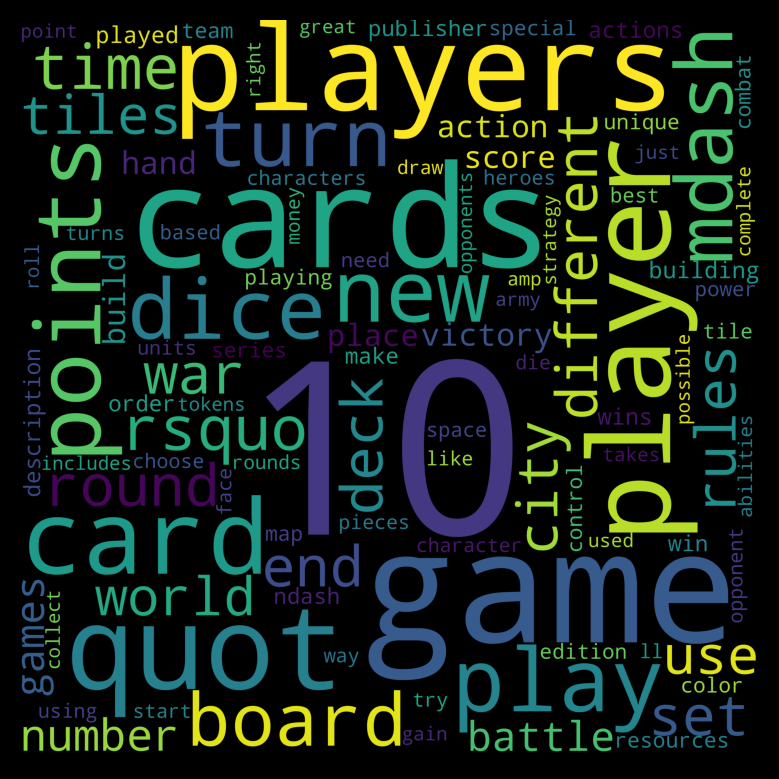

In [80]:
make_wordcloud(df_tfidf.T.sum(axis=1))

We'll use the cosine similarity between vectors. Because our scores come from the TF_IDF vecotrizer, we just need to calculate the dot product.

In [81]:
cos_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

In [82]:
def get_recommendations_tf_idf(bgg_id):

  # find the index of our game from database id
  game_rank = int(df[df['Game_ID'] == bgg_id]['Rank'])

  # get a list of tuples of the (index of game, TF_IDF similarity with given game)
  similarity_scores = list(enumerate(cos_similarity[game_rank-1]))

  # sort the list by highest scores and take the top 10 (not including original game)
  similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
  similarity_scores = similarity_scores[0:11]

  recomendations = pd.DataFrame()
  recomendations['Rank'] = [x[0]+1 for x in similarity_scores]
  recomendations['Distance'] = [x[1] for x in similarity_scores]
  
  return recomendations.merge(df, on='Rank').copy()

In [83]:
df_recs = get_recommendations_tf_idf(224517)
display_recommendations(df_recs)

Recomendations for Brass: Birmingham(2018) - 8.426
https://boardgamegeek.com/boardgame/224517

1. Brass: Lancashire(2007) - 7.967: https://boardgamegeek.com/boardgame/28720
	Test your economic mettle as you build and network in the Industrial Revolution.

2. Age of Industry(2010) - 6.622: https://boardgamegeek.com/boardgame/65901
	

3. Brass Empire(2016) - 5.664: https://boardgamegeek.com/boardgame/181393
	Corporations, employ the best, build factories & steam engines, sabotage and win.

4. HeroQuest(1989) - 6.825: https://boardgamegeek.com/boardgame/699
	Explore dungeons and complete quests in this RPG-inspired fantasy adventure.

5. Canal Mania(2006) - 6.053: https://boardgamegeek.com/boardgame/19995
	Take contracts, engage engineers and place goods to build and use British canals.

6. Dragon Brew(2017) - 5.632: https://boardgamegeek.com/boardgame/200280
	

7. A Game of Thrones: The Card Game(2008) - 6.457: https://boardgamegeek.com/boardgame/39953
	Command Westeros' factions and plo

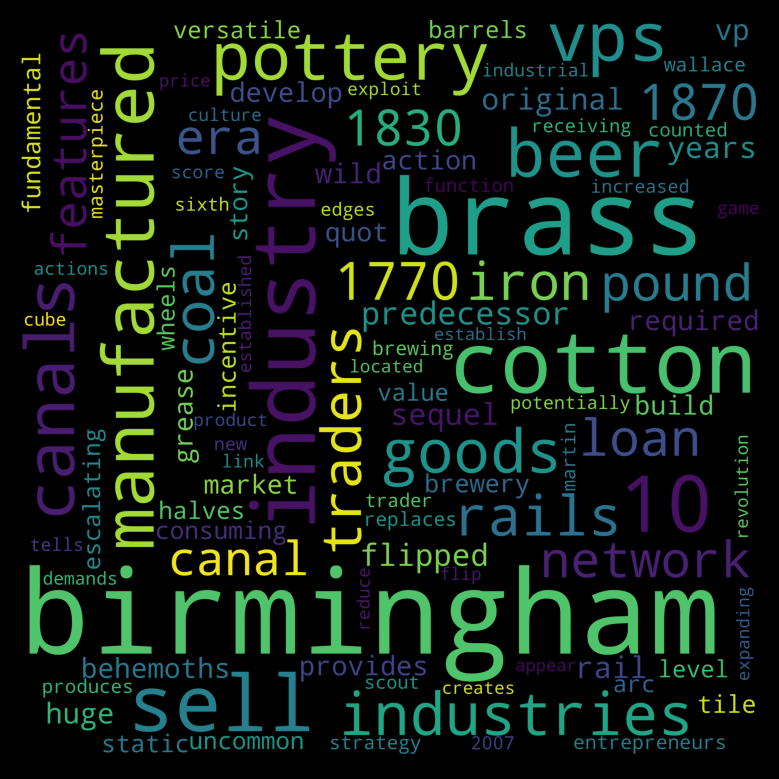

In [94]:
make_wordcloud(df_tfidf.loc['Brass: Birmingham'], filter_zeroes=True)

In [86]:
df_recs = get_recommendations_tf_idf(171)
display_recommendations(df_recs)

Recomendations for Chess(1475) - 6.996
https://boardgamegeek.com/boardgame/171

1. No Stress Chess(2004) - 5.572: https://boardgamegeek.com/boardgame/19918
	Play the world's greatest game, simplified for youngsters!

2. Martian Chess(1995) - 5.647: https://boardgamegeek.com/boardgame/19803
	Capture your opponent's pieces before they cross the Canal and become yours.

3. Six Making(2013) - 5.7: https://boardgamegeek.com/boardgame/149910
	

4. Bughouse Chess(1960) - 5.785: https://boardgamegeek.com/boardgame/14188
	

5. Shuuro(2008) - 5.582: https://boardgamegeek.com/boardgame/38764
	Discard the traditional chess set and build a custom army to conquer the board.

6. 4 Player Chess(1881) - 5.564: https://boardgamegeek.com/boardgame/2173
	Chess with 4 players instead of 2. It can be partners or everyone for themselves.

7. Proteus(2001) - 5.609: https://boardgamegeek.com/boardgame/2211
	Make chess moves and attacks with dice...then change their personae.

8. Paco Ŝako(2017) - 5.681: https:

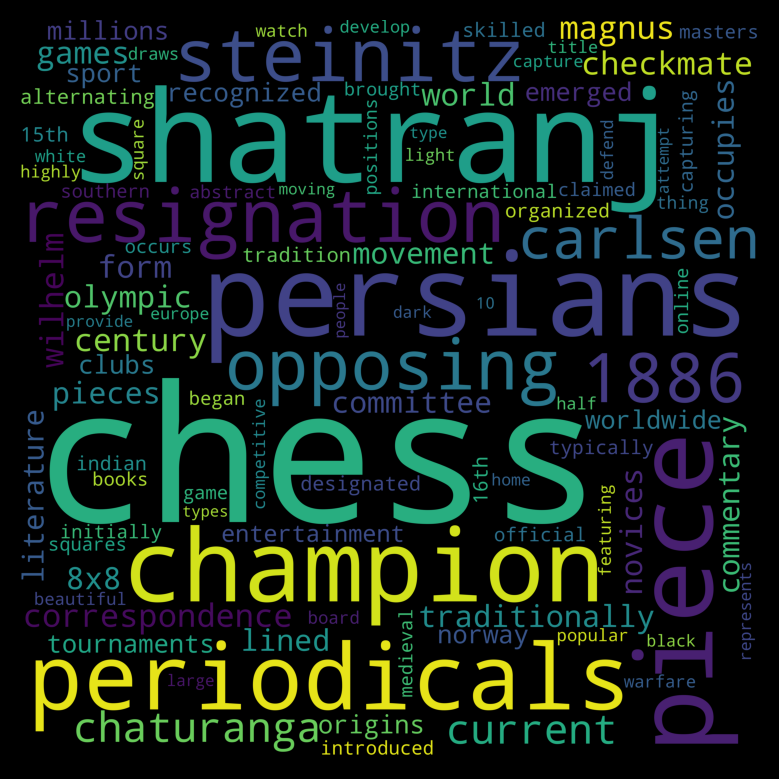

In [93]:
make_wordcloud(df_tfidf.loc['Chess'], filter_zeroes=True)

Chess being such a unique word, we get a bunch of chess variants and other games that mention chess-like play.

In [87]:
df_recs = get_recommendations_tf_idf(13)
display_recommendations(df_recs)

Recomendations for CATAN(1995) - 6.938
https://boardgamegeek.com/boardgame/13

1. The Settlers of Zarahemla(2003) - 5.777: https://boardgamegeek.com/boardgame/6778
	

2. Simply Catan(2006) - 5.607: https://boardgamegeek.com/boardgame/24511
	

3. Struggle for Catan(2011) - 5.844: https://boardgamegeek.com/boardgame/91534
	Gather, trade and then spend resources to grow your own Catanian empire.

4. Settlers of Catan: Gallery Edition(2008) - 5.727: https://boardgamegeek.com/boardgame/38821
	

5. Rivals for Catan(2010) - 6.59: https://boardgamegeek.com/boardgame/66056
	Duel to build the best kingdom in different eras of Catan.

6. Catan: Family Edition(2012) - 5.631: https://boardgamegeek.com/boardgame/147240
	

7. Elasund: The First City(2005) - 6.182: https://boardgamegeek.com/boardgame/19526
	Build & fortify city together. Make sure that pirates will plunder others, not you.

8. Catan: Traveler – Compact Edition(2015) - 5.752: https://boardgamegeek.com/boardgame/172994
	Collect and trad

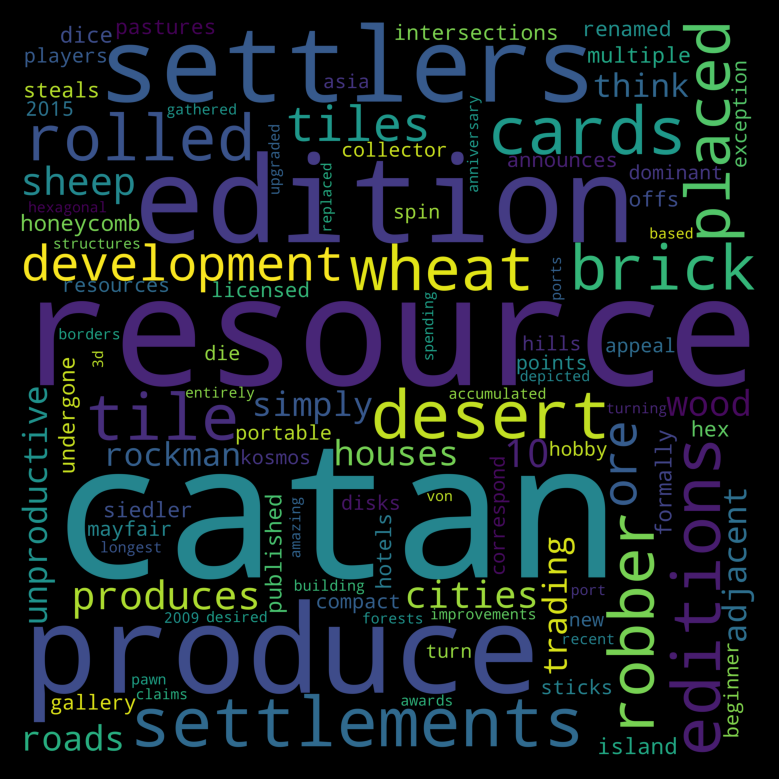

In [92]:
make_wordcloud(df_tfidf.loc['CATAN'])

In [88]:
df_recs = get_recommendations_tf_idf(320)
display_recommendations(df_recs)

Recomendations for Scrabble(1948) - 6.15
https://boardgamegeek.com/boardgame/320

1. Scarabeo(1963) - 5.635: https://boardgamegeek.com/boardgame/12747
	

2. Upwords(1982) - 5.617: https://boardgamegeek.com/boardgame/1515
	A 3-dimensional word game. Spell out, stack up and score high!

3. Das perfekte Wort(2021) - 5.6: https://boardgamegeek.com/boardgame/326112
	Find the perfect word for the perfect score.

4. Prolix(2010) - 5.616: https://boardgamegeek.com/boardgame/39635
	

5. Kiitos(2020) - 5.568: https://boardgamegeek.com/boardgame/300509
	Form words with letters that may or may not be in your opponents' hands.

6. Jarnac(1977) - 5.607: https://boardgamegeek.com/boardgame/7451
	Make the longest words possible or extend existing ones until 8 lines are completed.

7. A Little Wordy(2021) - 5.857: https://boardgamegeek.com/boardgame/335869
	A sneaky tile-unscrambling game for aspiring geniuses and would-be word wizards.

8. Letter Jam(2019) - 6.679: https://boardgamegeek.com/boardgame/

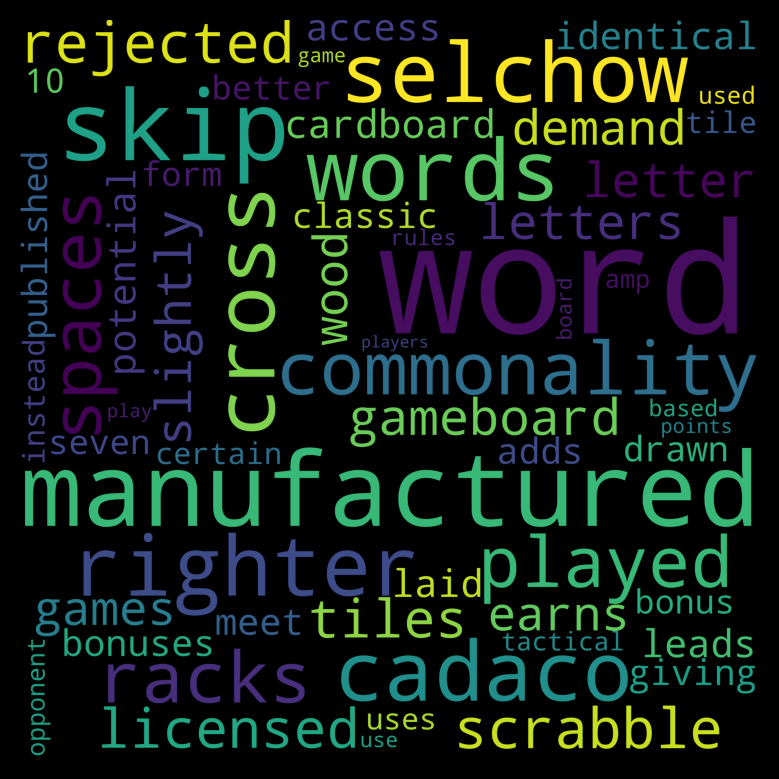

In [91]:
make_wordcloud(df_tfidf.loc['Scrabble'], filter_zeroes=True)

In [89]:
df_recs = get_recommendations_tf_idf(100423)
display_recommendations(df_recs)

Recomendations for Elder Sign(2011) - 6.8
https://boardgamegeek.com/boardgame/100423

1. Cthulhu: A Deck Building Game(2016) - 5.645: https://boardgamegeek.com/boardgame/192116
	

2. Fate of the Elder Gods(2017) - 6.108: https://boardgamegeek.com/boardgame/198609
	Summon ancient evil as ever-maddening cultists while avoiding pesky investigators.

3. Arkham Horror(2005) - 7.035: https://boardgamegeek.com/boardgame/15987
	Work as a team to save the town of Arkham from monsters and a Great Old One.

4. Arkham Horror (Third Edition)(2018) - 7.138: https://boardgamegeek.com/boardgame/257499
	Piece the clues together to stop the horrors before your sanity shatters.

5. Pandemic: Reign of Cthulhu(2016) - 6.99: https://boardgamegeek.com/boardgame/192153
	Close portals, shut down cultists, and stave off insanity before an Old One awakens.

6. Eldritch Horror(2013) - 7.525: https://boardgamegeek.com/boardgame/146021
	An unknown Ancient One approaches the world—and you must solve mysteries to sto

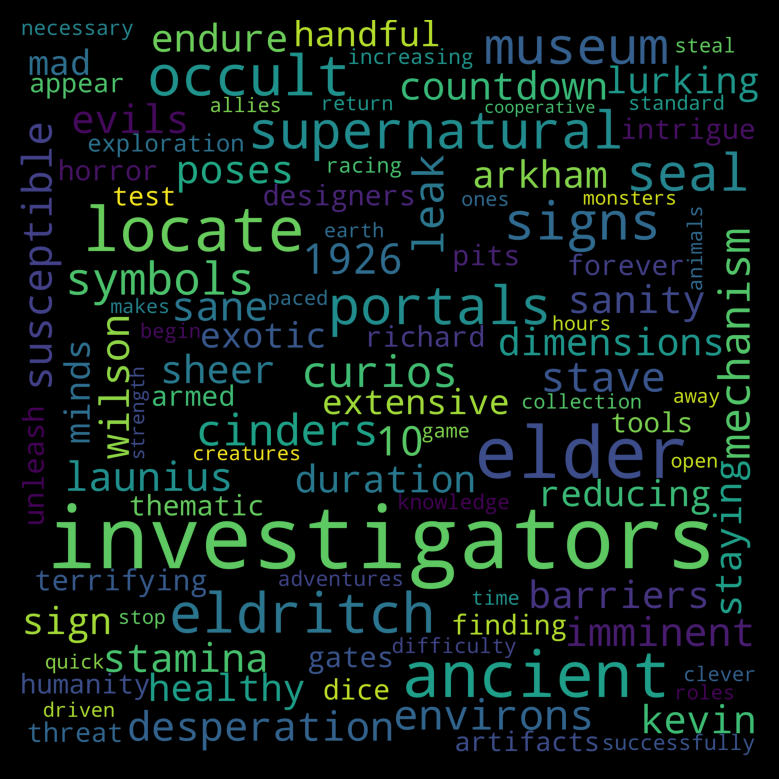

In [90]:
make_wordcloud(df_tfidf.loc['Elder Sign'], filter_zeroes=True)

# Conclusions

We've successfully made two recommendation systems. 

The first used categorical information about the games in the database and calculated the closely related neighbors based on euclidean distances. It was highly successful in finding related games that shared a lot of these human-generated tags. If a game did not have many of these, the system struggled to find appropriate recommendations.

The second system used a TF-IDF measurement using the long descriptions of each game. Games that shared unusual terms between their descriptions ended up being more closely related. This approach helped with games that did not have many of the human-generated tags. It wasn't alwyas good at finding mechanically related games.

On the whole, I think the first system performed better. BGG's database has been continually maintained for over twenty years. The categorical tags associated with each game are a good heuristic in finding similar games. The second recommendation system would fit well has a backup in the case that there are not enough detailed categories for the first system to give appropriate recommendations.